# Experiments with a deep Convolutional Neural Network

Importing libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import get_clf_report_dfs, plot_confusion_matrix

Defining constants:

In [2]:
RANDOM_SEED=42
MODEL_NAME="deepCNN"
RESULTS_DIR=f"./results/{MODEL_NAME}"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

Loading the data:

In [3]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
y_mapping = data['y_mapping']

Defining the network architecture. It corresponds to the encoder of the U-Net in the Deep Attentive Time Warping approach:

In [4]:
class deepCNN:
    def __init__(self, input_shape, num_classes, learning_rate=1e-4):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
    
    def double_conv(self, filters):
        return tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters, 3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv1D(filters, 3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
        ])

    def build(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))

        model.add(self.double_conv(64))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(128))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(256))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(512))
        model.add(tf.keras.layers.MaxPooling1D(2))

        model.add(self.double_conv(1024))
        model.add(tf.keras.layers.GlobalAveragePooling1D())

        model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
        
        return model

Building the model:

In [5]:
model = deepCNN(
    input_shape=X_train.shape[1:],
    num_classes=y_train.shape[0],
).build()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 150, 64)        │        13,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 75, 128)        │        75,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 37, 256)        │       297,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 18, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 18, 512)        │     1,184,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 9, 1024)        │     4,728,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 643)            │       659,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,958,851 (26.55 MB)

 Trainable params: 6,950,915 (26.52 MB)

 Non-trainable params: 7,936 (31.00 KB)

Fitting the model:

In [6]:
num_epochs = 500
batch_size = 16

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[
        early_stopping,
        lr_scheduler
    ],
    verbose=1
)
model.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}.keras"))

Epoch 1/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 4.4719 - sparse_categorical_accuracy: 0.3027 - val_loss: 6.0584 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 2/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 1.1577 - sparse_categorical_accuracy: 0.7258 - val_loss: 5.5895 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 3/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.5873 - sparse_categorical_accuracy: 0.8555 - val_loss: 5.2132 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 4/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.2762 - sparse_categorical_accuracy: 0.9684 - val_loss: 4.9252 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 5/500
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9979 - val_loss: 4.7979 - val_sparse_categorical_accuracy: 0.0625 - learning_rate: 1.0000e-04
Epoch 6/500
41/41 ━━━━━━━━━━━━

Visualizing the learning curves:

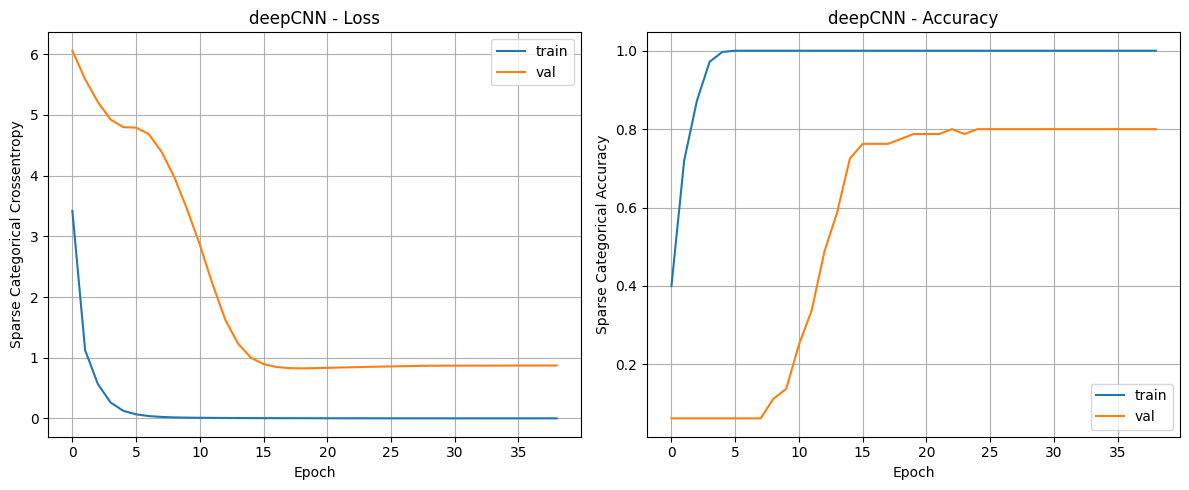

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history["loss"], label="train")
ax1.plot(history.history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Loss")
ax1.set_ylabel("Sparse Categorical Crossentropy")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(history.history["sparse_categorical_accuracy"], label="train")
ax2.plot(history.history["val_sparse_categorical_accuracy"], label="val")
ax2.set_title(f"{MODEL_NAME} - Accuracy")
ax2.set_ylabel("Sparse Categorical Accuracy")
ax2.set_xlabel("Epoch")
ax2.grid()
ax2.legend()

fig.tight_layout()

Displaying model loss and accuracy:

In [8]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
val_loss, val_accuracy = model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
pd.DataFrame({
    "Dataset": ["Train", "Val", "Test"],
    "Loss": [train_loss, val_loss, test_loss],
    "Accuracy": [train_accuracy, val_accuracy, test_accuracy]
}).set_index("Dataset")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9804
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7977 - sparse_categorical_accuracy: 0.7625
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.7554


,Loss,Accuracy
Dataset,,
Train,0.055250,0.986003
Val,0.825075,0.775000
Test,1.094252,0.753086


Displaying model performance on the test set:

In [9]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

np.save(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_predictions.npy"), y_pred)

y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_per_class_clf_scores.csv")
)

clf_scores_df

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.753086,0.749097,0.742187,0.772269,0.767196,0.762745,0.753086


In [10]:
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,0.500000,0.250000,0.333333,4.000000
bigball,0.500000,0.800000,0.615385,5.000000
box,0.666667,1.000000,0.800000,4.000000
button,0.600000,0.500000,0.545455,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,1.000000,0.750000,0.857143,4.000000
cylinder,0.666667,0.400000,0.500000,5.000000
empty,1.000000,1.000000,1.000000,5.000000
jenga,0.800000,1.000000,0.888889,4.000000
labello,0.750000,0.600000,0.666667,5.000000


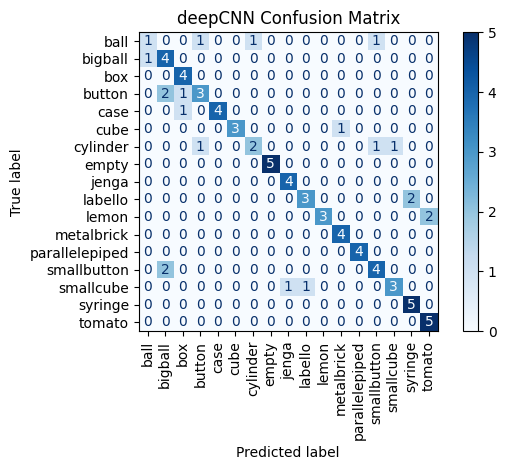

In [11]:
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_confusion_matrix.png")
)